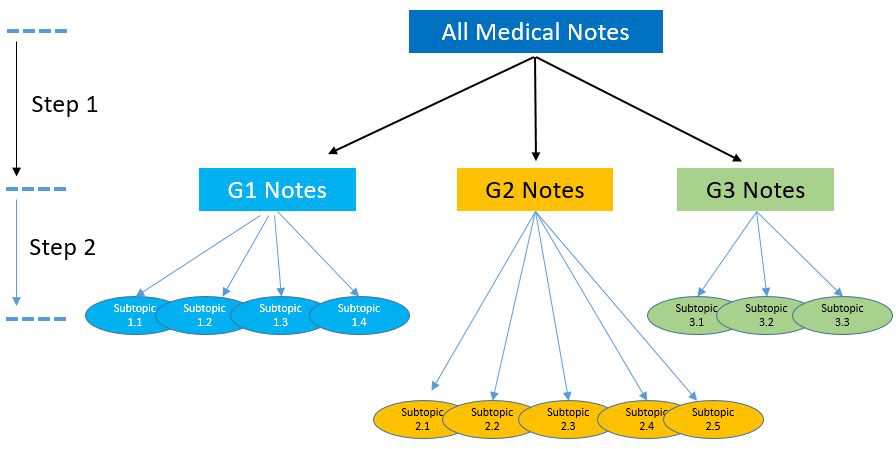

In [1]:
%matplotlib inline

import os
os.chdir(r"C:\Users\dwang\Documents\Tech Docs\Python\Topic Modeling\Post")

from IPython.display import display # to display images
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

pil_im = Image.open('Figure 1.jpg', 'r')
display(pil_im)

# Data Extraction

In [2]:
import pyodbc
import pandas as pd

server='DEREK-PC\EXPRESS2017'
db= 'RenesanRpt'
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + server + ';DATABASE=' + db + ';Trusted_Connection=yes')


sqlStr = '''
      SELECT [patient_id]
      ,[User_Id]
      ,[ContinuationDate]
      ,case when Menu = 'DietitianEvaluation' then 'G2 Notes'
            when Menu = 'Nursing' then 'G1 Notes'
            when Menu = 'SocialWorkerEvalution' then 'G3 Notes'
       end as Category
      ,[ContinuationNotes] Notes
      FROM [RenesanRpt].[dbo].[DailyNotes]
      where [ContinuationNotes] is not null
      and ContinuationDate < '2019-01-01'
      and ContinuationDate >= '2018-01-01'
      and Menu in ('Nursing','DietitianEvaluation','SocialWorkerEvalution')
      --order by Continuation_id
''' 

df1 = pd.io.sql.read_sql(sqlStr, conn)
df1.head(1)


,patient_id,User_Id,ContinuationDate,Category,Notes
0,798,80,2018-11-21,G3 Notes,The sw visited the pt and the pt asked abo...


In [4]:
G1 = df1[df1['Category']== 'G1 Notes']
G1.reset_index(inplace=True, drop=True)
len(G1)

14720

In [5]:
G1.tail()

,patient_id,User_Id,ContinuationDate,Category,Notes
14715,481,173,2018-01-05,G1 Notes,Pt seen by Dr. Adrogue on rounds today; lab...
14716,796,264,2018-09-28,G1 Notes,Mrs. Constance Bland is a 60 year old Afric...
14717,111,325,2018-03-05,G1 Notes,Departed 2.5kg >;tw after gaining 5.9kg and...
14718,111,214,2018-02-28,G1 Notes,Completed and tolerated treatment well. no ...
14719,798,306,2018-11-12,G1 Notes,NP-V. Edquilang rounded ordered to increas...


# Text Data Preprocessing

In [11]:
import warnings
warnings.simplefilter("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
#nltk.download('wordnet')

stemmer = nltk.stem.SnowballStemmer('english')
#stemmer = nltk.stem.PorterStemmer()

# lematize and stemming 先词形还原再提取词干
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text, n):    # n: the minimum length of a word
    result = []
    for token in gensim.utils.simple_preprocess(text):   # convert document into tokens
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > n:
            result.append(lemmatize_stemming(token))
    return ' '.join(result)



G1_processed_docs = G1['Notes'].apply(lambda x: preprocess(x, 2))
G1_processed_docs = list(G1_processed_docs)

# Convert processed notes to count vector
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

Count_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=4500,
                                stop_words='english')

G1_cv = Count_vectorizer.fit_transform(G1_processed_docs)


In [12]:
len(G1_processed_docs)

14720

# Preliminary Topic Test

In [16]:
n_testTpoics = 5

G1_lda = LatentDirichletAllocation(n_components  = 5,max_iter=5,
                                learning_method='online',
                                learning_offset=50.
                               )
G1_lda.fit(G1_cv)
G1_LdaRstMatrix = G1_lda.transform(G1_cv)
G1_LdaRst = G1_LdaRstMatrix.argmax(axis=1)

In [21]:
G1_LdaRstMatrix[:5,]

array([[0.93775826, 0.00912289, 0.00927636, 0.00920904, 0.03463346],
       [0.02554828, 0.02516853, 0.89905023, 0.02519609, 0.02503686],
       [0.2125262 , 0.02002172, 0.7262081 , 0.02092995, 0.02031403],
       [0.03334403, 0.03334622, 0.03333363, 0.03340827, 0.86656786],
       [0.88375452, 0.02880076, 0.02864583, 0.02868606, 0.03011285]])

In [23]:
G1_LdaRst[:5,]

array([0, 2, 2, 4, 0], dtype=int64)

In [24]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(G1_lda, G1_cv, Count_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
2      32.834505        1       1  -80.267258   -3.661817
3      27.269676        1       2  -52.365261 -135.701782
0      19.336504        1       3 -107.433235  -80.142326
1      11.339795        1       4   24.351788 -109.210899
4       9.219520        1       5  -10.077559  -38.714046, topic_info=     Category         Freq       Term        Total  loglift  logprob
2578  Default  8204.000000      order  8204.000000  30.0000  30.0000
3235  Default  3268.000000      round  3268.000000  29.0000  29.0000
4063  Default  4124.000000       week  4124.000000  28.0000  28.0000
2251  Default  3595.000000        mcg  3595.000000  27.0000  27.0000
252   Default  2851.000000    aranesp  2851.000000  26.0000  26.0000
1460  Default  3554.000000      fluid  3554.000000  25.0000  25.0000
3757  Default  3049.000000      today  3049.000000  24.0000  24.0000
1209  Default  3112.000000        edw  3112.000000  23.0000  23.0000
3742  Default  3641.000000       time  3641.000000  22.0000  22.0000
922   Default  2812.000000    current  2812.000000  21.0000  21.0000
2028  Default  3122.000000        lab  3122.000000  20.0000  20.0000
2909  Default  1684.000000   protocol  1684.000000  19.0000  19.0000
3184  Default  2195.000000     review  2195.000000  18.0000  18.0000
846   Default  4246.000000    continu  4246.000000  17.0000  17.0000
2363  Default  3353.000000      month  3353.000000  16.0000  16.0000
1150  Default  2229.000000       draw  2229.000000  15.0000  15.0000
1837  Default  2339.000000    increas  2339.000000  14.0000  14.0000
3027  Default  3152.000000     receiv  3152.000000  13.0000  13.0000
2681  Default  7000.000000    patient  7000.000000  12.0000  12.0000
2359  Default  2115.000000    monitor  2115.000000  11.0000  11.0000
983   Default  1501.000000    decreas  1501.000000  10.0000  10.0000
602   Default  1521.000000      carri  1521.000000   9.0000   9.0000
2447  Default  1601.000000        new  1601.000000   8.0000   8.0000
2993  Default  2175.000000       rang  2175.000000   7.0000   7.0000
2263  Default  1919.000000      medic  1919.000000   6.0000   6.0000
3981  Default  1242.000000      venof  1242.000000   5.0000   5.0000
2817  Default  1326.000000  potassium  1326.000000   4.0000   4.0000
2514  Default  2557.000000       nurs  2557.000000   3.0000   3.0000
382   Default  1081.000000       bath  1081.000000   2.0000   2.0000
1207  Default  1091.000000       educ  1091.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
4029   Topic5     7.843934      vupal     8.673753   2.2833  -8.2558
2580   Topic5     7.693165       ordr     8.513898   2.2825  -8.2752
2056   Topic5    93.500298     latest   103.766207   2.2797  -5.7776
1388   Topic5   322.626022        fax   403.233352   2.1608  -4.5390
252    Topic5  1999.711629    aranesp  2851.367041   2.0291  -2.7148
983    Topic5  1084.157331    decreas  1501.327819   2.0583  -3.3270
2251   Topic5  2355.870133        mcg  3595.871545   1.9610  -2.5509
2282   Topic5   548.737487        meq   791.204719   2.0179  -4.0079
4063   Topic5  2524.344908       week  4124.295511   1.8929  -2.4818
1837   Topic5  1322.145960    increas  2339.289864   1.8133  -3.1285
382    Topic5   653.852982       bath  1081.362798   1.8808  -3.8326
3981   Topic5   673.799233      venof  1242.726194   1.7717  -3.8026
4156   Topic5   604.524486    zemplar  1097.568132   1.7874  -3.9111
1150   Topic5  1095.889068       draw  2229.414232   1.6737  -3.3162
3155   Topic5   106.197160    restart   154.181811   2.0110  -5.6502
3920   Topic5   266.578585      updat   463.153560   1.8315  -4.7299
2359   Topic5   932.183844    monitor  2115.624475   1.5643  -3.4780
2578   Topic5  2852.063369      order  8204.898264   1.3272  -2.3597
3508   Topic5   659.473845      start  1396.463722   1.6336  -3.8241
2263   Topic5   843.562595      

In [29]:
G1_Topic = pd.DataFrame(G1_processed_docs, columns = ['ProcessedDoc'])
G1_Topic['epo'] = G1_Topic['ProcessedDoc'].str.contains('aranesp').astype('int')
G1_Topic['epo'].value_counts()

0    11985
1     2735
Name: epo, dtype: int64

In [30]:
G1_SubTopic.head(10)

,ProcessedDoc,epo
0,complet toler treatment edw naik awar fluid ov...,0
1,treatment give patient hospit memori hermann t...,0
2,remain hospit mem hermann hosp med center jone...,0
3,aranesp decreas mcg qow protocol,1
4,gain bodi mass edw increas notifi,0
5,decreas edw report loss bodi mass establish tr...,0
6,patient lose bodi mass edw adjust accord order...,0
7,patient call speak staff state come today sche...,0
8,zemplar increas mcg protocol,0
9,frome okay ultrafiltr hour today treatment pat...,0


In [61]:
def optimizeRandomState(RS, NT):
    G1_lda = LatentDirichletAllocation(n_components = NT,
                                       max_iter=2,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state = RS
                                      )
    
    G1_lda.fit(G1_cv)
    G1_LdaRst = G1_lda.transform(G1_cv)
    G1_LdaRst = G1_LdaRst.argmax(axis=1)

    G1_Topic['Topic'] = G1_LdaRst
    ss = G1_Topic.groupby(['epo','Topic']).count().reset_index()
    ss = ss.rename(columns = {'ProcessedDoc':'DocCounts'})
    
    print(pd.pivot_table(ss, values = 'DocCounts', columns  = ['Topic'], index = ['epo']))

    TargetTopic = ss.loc[(ss['epo'] == 1) & 
                    (ss['DocCounts'] == max(ss['DocCounts'].loc[ss['epo']==1]))
                    ,"Topic"].values[0]
    print(TargetTopic)
    fp = ss['DocCounts'][ (ss['epo']==0) & (ss['Topic']==TargetTopic) ].values[0]
    tp = ss['DocCounts'][ (ss['epo']==1) & (ss['Topic']==TargetTopic) ].values[0]
    precision = tp/(fp + tp)
    recall = tp/(sum(ss['DocCounts'][ss['epo']==1]))
    f1 = 2 * precision * recall / (precision + recall)
    
    score = G1_lda.score(G1_cv)
    perplexity = G1_lda.perplexity(G1_cv)
    
    return [RS, NT, precision,recall, f1, score, perplexity]

In [62]:
RstList = []
NT = 9

for RS in range(20):    
    print('Now testing RS ', RS)
    lst =  optimizeRandomState(RS, NT)
    RstList.append(lst)

Now testing RS  0
Topic    0    1    2     3     4     5     6     7     8
epo                                                     
0      503  658  398  1217  2330  2578  1327  1758  1216
1        6  270  795    19     5     8     1    88  1543
8
Now testing RS  1
Topic       0      1      2       3       4      5      6      7      8
epo                                                                    
0      1826.0  206.0  383.0  2983.0  4014.0  910.0  299.0  591.0  773.0
1       971.0   10.0  816.0    34.0   523.0  379.0    NaN    NaN    2.0
0
Now testing RS  2
Topic    0     1     2     3     4    5     6     7    8
epo                                                     
0      436  2507  1024  1191  1032  983  1824  2128  860
1        5    12   776  1523   371   17    26     3    2
3
Now testing RS  3
Topic     0    1    2    3     4     5     6     7    8
epo                                                    
0      2965  246  197  578  1060  3247  1185  1928  579
1        2

In [63]:
RstDf = pd.DataFrame(RstList, columns = ['RS', 'NT', 'precision','recall', 'f1'])
RstDf

,RS,NT,precision,recall,f1
0,0,9,0.559261,0.564168,0.561704
1,1,9,0.347158,0.355027,0.351048
2,2,9,0.561164,0.556856,0.559002
3,3,9,0.304860,0.520658,0.384553
4,4,9,0.662811,0.817185,0.731947
5,5,9,0.439811,0.543693,0.486266
6,6,9,0.550320,0.533821,0.541945
7,7,9,0.338248,0.721389,0.460551
8,8,9,0.651495,0.717002,0.682681
9,9,9,0.623292,0.700548,0.659666


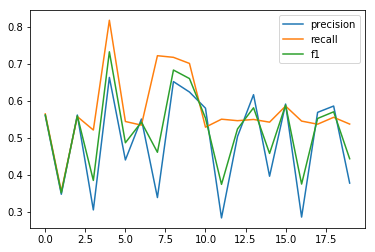

In [66]:
plt.plot(RstDf.RS, RstDf.precision)
plt.plot(RstDf.RS, RstDf.recall)
plt.plot(RstDf.RS, RstDf.f1)
plt.legend()

# Optimize Max Iter

In [102]:
def optimizeMaxIter(MaxIter):
    G1_lda = LatentDirichletAllocation(n_components = 9,
                                       max_iter=MaxIter,
                                        learning_method='online',
                                        learning_offset=500.,
                                        random_state = 4
                                      )
    
    G1_lda.fit(G1_cv)
    G1_LdaRst = G1_lda.transform(G1_cv)
    G1_LdaRst = G1_LdaRst.argmax(axis=1)

    G1_Topic['Topic'] = G1_LdaRst
    ss = G1_Topic.groupby(['epo','Topic']).count().reset_index()
    ss = ss.rename(columns = {'ProcessedDoc':'DocCounts'})
    
    print(pd.pivot_table(ss, values = 'DocCounts', columns  = ['Topic'], index = ['epo']))

    TargetTopic = ss.loc[(ss['epo'] == 1) & 
                    (ss['DocCounts'] == max(ss['DocCounts'].loc[ss['epo']==1]))
                    ,"Topic"].values[0]
    print(TargetTopic)
    fp = ss['DocCounts'][ (ss['epo']==0) & (ss['Topic']==TargetTopic) ].values[0]
    tp = ss['DocCounts'][ (ss['epo']==1) & (ss['Topic']==TargetTopic) ].values[0]
    precision = tp/(fp + tp)
    recall = tp/(sum(ss['DocCounts'][ss['epo']==1]))
    f1 = 2 * precision * recall / (precision + recall)
    
    score = G1_lda.score(G1_cv)
    perplexity = G1_lda.perplexity(G1_cv)
    
    
    return [MaxIter, precision,recall, f1, score, perplexity]

In [103]:
RstList = []
for MaxIter in range(1, 11):    
    print('Now testing MaxIter ', MaxIter)
    lst =  optimizeMaxIter(MaxIter)
    RstList.append(lst)

Now testing MaxIter  1
Topic      0       1      2       3       4       5      6      7     8
epo                                                                    
0      806.0  2384.0  288.0  2502.0  4211.0  1498.0  150.0  120.0  26.0
1        NaN    16.0    NaN    67.0  2386.0   266.0    NaN    NaN   NaN
4
Now testing MaxIter  2
Topic      0       1      2       3       4       5      6       7     8
epo                                                                     
0      826.0  2523.0  411.0  2703.0  1712.0  1457.0  168.0  2133.0  52.0
1        NaN    27.0    4.0    38.0  2298.0   311.0    NaN     6.0  51.0
4
Now testing MaxIter  3
Topic      0       1      2       3       4       5      6       7     8
epo                                                                     
0      835.0  2571.0  535.0  2768.0  1438.0  1338.0  175.0  2272.0  53.0
1        NaN    25.0   11.0    24.0  2274.0   340.0    NaN    10.0  51.0
4
Now testing MaxIter  4
Topic      0       1      2   

In [104]:
RstDf = pd.DataFrame(RstList, columns = ['MaxIter', 'precision','recall', 'f1', 'score','perplexity'])

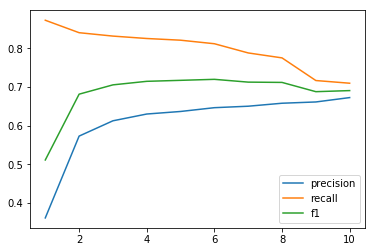

In [105]:
plt.plot(RstDf.MaxIter  , RstDf.precision)
plt.plot(RstDf.MaxIter  , RstDf.recall)
plt.plot(RstDf.MaxIter  , RstDf.f1)
plt.legend()

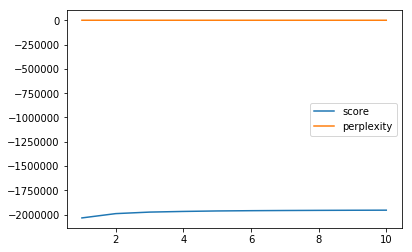

In [106]:
plt.plot(RstDf.MaxIter  , RstDf.score)
plt.plot(RstDf.MaxIter  , RstDf.perplexity)
plt.legend()

In [107]:
RstDf

,MaxIter,precision,recall,f1,score,perplexity
0,1,0.361680,0.872395,0.511359,-2.033303e+06,496.598842
1,2,0.573067,0.840219,0.681394,-1.989034e+06,433.817822
2,3,0.612608,0.831444,0.705444,-1.973449e+06,413.660362
3,4,0.630095,0.825229,0.714580,-1.966622e+06,405.127060
4,5,0.636699,0.820841,0.717138,-1.961672e+06,399.051145
5,6,0.646476,0.811700,0.719728,-1.958908e+06,395.696864
6,7,0.650272,0.787934,0.712514,-1.957042e+06,393.450046
7,8,0.657976,0.775137,0.711768,-1.955585e+06,391.703243
8,9,0.661269,0.716636,0.687840,-1.954486e+06,390.390760
9,10,0.672557,0.709689,0.690624,-1.953653e+06,389.400107


In [108]:
def optimizeNumTopics(NumTopic):
    G1_lda = LatentDirichletAllocation(n_components = NumTopic,
                                       max_iter=3,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state = 4
                                      )
    
    G1_lda.fit(G1_cv)
    G1_LdaRst = G1_lda.transform(G1_cv)
    G1_LdaRst = G1_LdaRst.argmax(axis=1)

    G1_Topic['Topic'] = G1_LdaRst
    ss = G1_Topic.groupby(['epo','Topic']).count().reset_index()
    ss = ss.rename(columns = {'ProcessedDoc':'DocCounts'})
    
    print(pd.pivot_table(ss, values = 'DocCounts', columns  = ['Topic'], index = ['epo']))

    TargetTopic = ss.loc[(ss['epo'] == 1) & 
                    (ss['DocCounts'] == max(ss['DocCounts'].loc[ss['epo']==1]))
                    ,"Topic"].values[0]
    print(TargetTopic)
    fp = ss['DocCounts'][ (ss['epo']==0) & (ss['Topic']==TargetTopic) ].values[0]
    tp = ss['DocCounts'][ (ss['epo']==1) & (ss['Topic']==TargetTopic) ].values[0]
    precision = tp/(fp + tp)
    recall = tp/(sum(ss['DocCounts'][ss['epo']==1]))
    f1 = 2 * precision * recall / (precision + recall)
    
    score = G1_lda.score(G1_cv)
    perplexity = G1_lda.perplexity(G1_cv)
    
    
    return [NumTopic, precision,recall, f1, score, perplexity]

In [109]:
RstList = []
for NumTopic in range(2, 20):    
    print('Now testing NumTopic ', NumTopic)
    lst =  optimizeNumTopics(NumTopic)
    RstList.append(lst)

Now testing NumTopic  2
Topic     0     1
epo              
0      4278  7707
1      1562  1173
0
Now testing NumTopic  3
Topic     0     1     2
epo                    
0      3387  3969  4629
1         6  1203  1526
2
Now testing NumTopic  4
Topic     0     1     2     3
epo                          
0      1901  4042  3590  2452
1      1520   411    40   764
0
Now testing NumTopic  5
Topic    0     1     2     3     4
epo                               
0      979  2938  3885  2764  1419
1       53    49   381    20  2232
4
Now testing NumTopic  6
Topic    0     1    2     3     4     5
epo                                    
0      984  3112  854  2596  1280  3159
1       53   195  192    10  2236    49
4
Now testing NumTopic  7
Topic    0     1    2     3     4     5    6
epo                                         
0      795  2867  606  2587  1283  2871  976
1        4    35    2     8  2279    36  371
4
Now testing NumTopic  8
Topic     0     1    2     3     4     5    6     7


In [110]:
RstDf = pd.DataFrame(RstList, columns = ['NumTopic', 'precision','recall', 'f1', 'score','perplexity'])

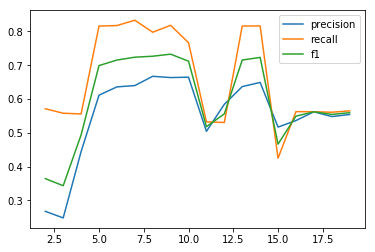

In [111]:
plt.plot(RstDf.NumTopic  , RstDf.precision)
plt.plot(RstDf.NumTopic  , RstDf.recall)
plt.plot(RstDf.NumTopic  , RstDf.f1)
plt.legend()

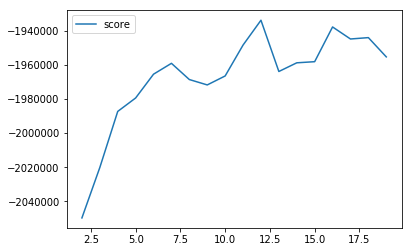

In [114]:
plt.plot(RstDf.NumTopic  , RstDf.score)
#plt.plot(RstDf.NumTopic  , RstDf.perplexity)
plt.legend()

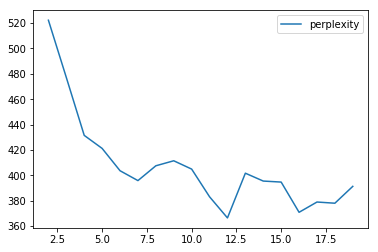

In [115]:
#plt.plot(RstDf.NumTopic  , RstDf.score)
plt.plot(RstDf.NumTopic  , RstDf.perplexity)
plt.legend()

In [116]:
RstDf

,NumTopic,precision,recall,f1,score,perplexity
0,2,0.267466,0.571115,0.364315,-2.049810e+06,522.266543
1,3,0.247929,0.557952,0.343307,-2.020185e+06,477.102742
2,4,0.444315,0.555759,0.493827,-1.987230e+06,431.435549
3,5,0.611339,0.816088,0.699029,-1.979331e+06,421.155555
4,6,0.635950,0.817550,0.715406,-1.965347e+06,403.553016
5,7,0.639809,0.833272,0.723837,-1.958965e+06,395.766235
6,8,0.667278,0.797806,0.726728,-1.968494e+06,407.448807
7,9,0.663504,0.818282,0.732809,-1.971659e+06,411.405127
8,10,0.664659,0.766728,0.712054,-1.966390e+06,404.840271
9,11,0.504330,0.532358,0.517965,-1.948231e+06,383.006188


In [124]:
def optimizeAlphaEta(alpha, eta):
    G1_lda = LatentDirichletAllocation(n_components = 9,
                                       max_iter=3,
                                       doc_topic_prior = alpha,
                                       topic_word_prior  = eta,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state = 4
                                      )
    
    G1_lda.fit(G1_cv)
    G1_LdaRst = G1_lda.transform(G1_cv)
    G1_LdaRst = G1_LdaRst.argmax(axis=1)

    G1_Topic['Topic'] = G1_LdaRst
    ss = G1_Topic.groupby(['epo','Topic']).count().reset_index()
    ss = ss.rename(columns = {'ProcessedDoc':'DocCounts'})
    
    #print(pd.pivot_table(ss, values = 'DocCounts', columns  = ['Topic'], index = ['epo']))

    TargetTopic = ss.loc[(ss['epo'] == 1) & 
                    (ss['DocCounts'] == max(ss['DocCounts'].loc[ss['epo']==1]))
                    ,"Topic"].values[0]
    #print(TargetTopic)
    fp = ss['DocCounts'][ (ss['epo']==0) & (ss['Topic']==TargetTopic) ].values[0]
    tp = ss['DocCounts'][ (ss['epo']==1) & (ss['Topic']==TargetTopic) ].values[0]
    precision = tp/(fp + tp)
    recall = tp/(sum(ss['DocCounts'][ss['epo']==1]))
    f1 = 2 * precision * recall / (precision + recall)
    
    score = G1_lda.score(G1_cv)
    perplexity = G1_lda.perplexity(G1_cv)
    
    print('F1 score is ', f1)
    
    return [alpha, eta, precision,recall, f1, score, perplexity]

In [125]:
RstList = []
for alpha in np.linspace(0,1,11):    
    for eta in np.linspace(0,1,11):
        print('\n Now testing alpha eta ', alpha, eta)
        lst =  optimizeAlphaEta(alpha, eta)
        RstList.append(lst)


 Now testing alpha eta  0.0 0.0
F1 score is  0.728821890873341

 Now testing alpha eta  0.0 0.1
F1 score is  0.7294272547728767

 Now testing alpha eta  0.0 0.2
F1 score is  0.729578392621871

 Now testing alpha eta  0.0 0.30000000000000004
F1 score is  0.7275720164609054

 Now testing alpha eta  0.0 0.4
F1 score is  0.7277211443604077

 Now testing alpha eta  0.0 0.5
F1 score is  0.7259283601708841

 Now testing alpha eta  0.0 0.6000000000000001
F1 score is  0.7252311756935271

 Now testing alpha eta  0.0 0.7000000000000001
F1 score is  0.7270919635459818

 Now testing alpha eta  0.0 0.8
F1 score is  0.726881007623467

 Now testing alpha eta  0.0 0.9
F1 score is  0.7292670766162539

 Now testing alpha eta  0.0 1.0
F1 score is  0.7300481168076987

 Now testing alpha eta  0.1 0.0
F1 score is  0.7315720808871494

 Now testing alpha eta  0.1 0.1
F1 score is  0.7285458394398306

 Now testing alpha eta  0.1 0.2
F1 score is  0.7290817158701679

 Now testing alpha eta  0.1 0.3000000000000000

In [126]:
RstDf = pd.DataFrame(RstList, columns = ['alpha', 'eta', 'precision','recall', 'f1', 'score','perplexity'])

In [127]:
RstDf[RstDf['f1']>0.73]

,alpha,eta,precision,recall,f1,score,perplexity
10,0.0,1.0,0.668287,0.804388,0.730048,NaN,NaN
11,0.1,0.0,0.660288,0.820110,0.731572,NaN,NaN
15,0.1,0.4,0.660651,0.816453,0.730335,-1.971487e+06,411.189912
16,0.1,0.5,0.661730,0.816819,0.731141,-1.975899e+06,416.765466
17,0.1,0.6,0.661228,0.814991,0.730102,-1.978213e+06,419.720555
32,0.2,1.0,0.722259,0.790128,0.754671,-2.009721e+06,462.102023


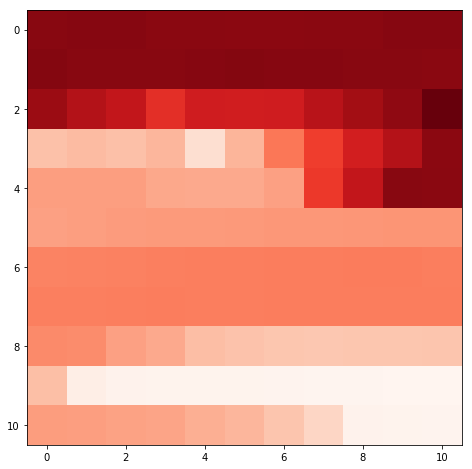

In [141]:
% matplotlib inline
plt.figure(figsize = (8,8))
plt.imshow(pd.pivot_table(RstDf[['alpha', 'eta', 'f1']], index = ['alpha'], values = 'f1', columns = ['eta']).values
          ,interpolation='nearest', cmap='Reds')